<a href="https://colab.research.google.com/github/solharsh/Computer_Vision/blob/master/Transfer_Learning_MXNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import pickle

#drive.mount('/content/drive')
DATA_PATH = "/content/drive/My Drive/Computer_vision/"
infile = open(DATA_PATH+'/training_data.pkl','rb')
df = pickle.load(infile)

In this example, we will use Transfer Learning. A pre-trained Alexnet is used to classify five image categories. You can see in the training loop that it only takes 5 epochs to reach the 98% validation accuracy.


1. DOWNLOAD AND READ THE DATASET

Our dataset is made of Amazon product images. We have 5 categories: "Ring", "Shirt", "Watch", "Jeans" and "Shoe".

We have the following classes:
* CLASS 0: RING
* CLASS 1: SHIRT
* CLASS 2: WATCH
* CLASS 3: JEANS
* CLASS 4: SHOE

Let's look at some examples. The first column of the numpy array holds images and second column keeps the class information. Classes are 0: Ring, 1: Shirt, 2: Watch, 3: Jeans, 4: Shoe


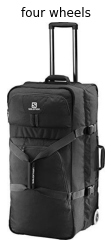

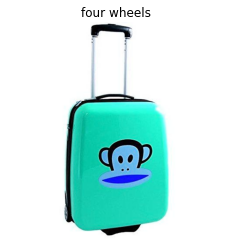

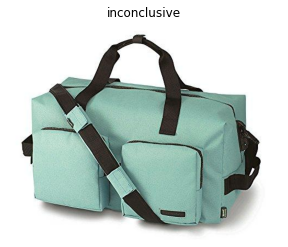

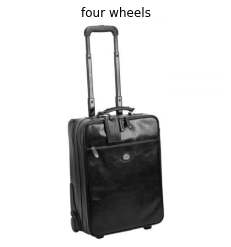

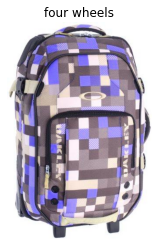

In [2]:
import matplotlib.pyplot as plt
 
classes = ['two wheels', 'four wheels', 'zero wheels', 'not a wheel', 'inconclusive']
 
plt.imshow(df["data"][551])
plt.title(classes[df["label"][551]])
plt.axis("off")
plt.show()
 
plt.imshow(df["data"][1119])
plt.title(classes[df["label"][1119]])
plt.axis("off")
plt.show()
 
plt.imshow(df["data"][156])
plt.title(classes[df["label"][156]])
plt.axis("off")
plt.show()
 
plt.imshow(df["data"][1526])
plt.title(classes[df["label"][1526]])
plt.axis("off")
plt.show()
 
plt.imshow(df["data"][15])
plt.title(classes[df["label"][15]])
plt.axis("off")
plt.show()

# 2. SPLIT THE DATASET AND PROCESS IMAGES
* We split the original dataset into Training (80%), Validation (10%) and Test (10%) subsets.
* We will process images by resizing to 224x224 and converting (row, column, channel) to (channel, row, column)


In [3]:
pip install mxnet

In [0]:
import numpy as np
from skimage.transform import resize
from mxnet import gluon
 
# Let's split to data into training (80%), validation (10%) and test (10%) subsets.
train_indices = np.arange(0, int(0.8*len(df)))
val_indices = np.arange(int(0.8*len(df)), int(0.9*len(df)))
test_indices = np.arange(int(0.9*len(df)), len(df))
 
train_df = df.iloc[train_indices]
val_df = df.iloc[val_indices]
test_df = df.iloc[test_indices]
 
del df
 
def getImages(images):
    # Create the image holder array
    image_arr = np.zeros((images.shape[0], 3, 224, 224), dtype="float32")
    
    # Iterate through the image data
    for i, im in enumerate(images):
        # Get image from the data column of the current row
        
        # We need a fixed size input, our images have different sizes, let's pick 224x224.
        # Resize image below
        im = resize(im, output_shape=(224, 224))
        
        # Gluon/mxnet expects images in this format (channel, row, column)
        # This is the opposite of (row, column, channel), let's fix it
        im = np.moveaxis(im, -1, 0)
        
        # Assign the value in the image array
        image_arr[i] = im
 
    return image_arr
    
train_images, train_labels = getImages(train_df["data"].values), train_df["label"].values
validation_images, validation_labels = getImages(val_df["data"].values), val_df["label"].values
 
# Using Gluon Data loaders to load the data in batches
train_dataset = gluon.data.ArrayDataset(train_images, train_labels)
validation_dataset = gluon.data.ArrayDataset(validation_images, validation_labels)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


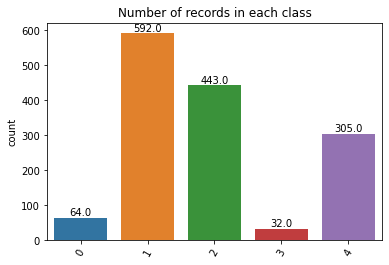

In [5]:
import matplotlib.pyplot as plt
import seaborn as sb
 
plt.figure()
ax = sb.countplot(x=train_labels, y = None)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate(y, (x.mean(), y), ha='center', va='bottom') 
plt.xticks(rotation=60)
plt.title('Number of records in each class')
plt.show()

# 3. BUILD THE CONVOLUTIONAL NEURAL NETWORK
We will use two Convolution-Pooling pairs
- Flatten after them
- A fully connected layer
- Dense output layer

In [0]:
from mxnet.gluon.model_zoo import vision
import mxnet as mx
 
def build_network(num_outputs):
    # Set this to GPU or CPU
    ctx = mx.gpu()
    #ctx = mx.cpu()
 
    # Get the pre-trained network
    pre_trained_net = vision.alexnet(pretrained=True, ctx=ctx)
 
    # Get the non-trained network
    net = vision.alexnet(classes=num_outputs, ctx=ctx)
    
    # Initialize weights
    net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
    
    # Copy weights from the trained network
    net.features = pre_trained_net.features
 
    return net

# 4. CONSTRUCT THE CONFUSION MATRIX PLOT FUNCTION
We will use this function to plot our confusion matrix at the end of each epoch. (Epoch: One full pass through our dataset)

In [0]:
#Let's write a function to plot a confusion matrix to see class-specific performance after each epoch

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index = [i for i in ['two wheels', 'four wheels', 'zero wheels', 'not a wheel', 'inconclusive']], columns = [i for i in ['two wheels', 'four wheels', 'zero wheels', 'not a wheel', 'inconclusive']])
    plt.figure(figsize = (5, 5))
    plt.title('Validation Confusion Matrix')
    sn.heatmap(df_cm, annot=True)
    plt.show()

# 5. TRAINING THE NETWORK
Let's put the training data in the MXnet format and start training. Summarizing our steps:
* Select the correct compute type cpu or gpu
* Split the dataset into training, validation and test splits
* Create Gluon-specific data loaders
* Create the network and training algorithm
* Loop through dataset. We have only 5 epochs thaks to pre-trained network. We will train with training dataset and validate with the validation dataset.

In [0]:
	
import numpy as np
from mxnet import gluon, autograd, ndarray
import mxnet as mx
import mxnet.ndarray as nd
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss
from sklearn.metrics import accuracy_score
 
# Set this to GPU or CPU 
#ctx = mx.gpu()
ctx = mx.cpu()
 
# Set the batch size
batch_size = 150
epochs = 5
learning_rate = 0.01
 
# ------ Create Network and Training Logic -------- #
 
# Create the network. We have 5 classes
num_outputs = 5
 
net = build_network(num_outputs)
 
# Define loss and trainer.
softmax_cross_etropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate})
# ------------------------------------------------- #
 
train_loader = gluon.data.DataLoader(train_dataset, batch_size=batch_size)
validation_loader = gluon.data.DataLoader(validation_dataset, batch_size=batch_size)
 
for epoch in range(epochs):
    
    # training loop (with autograd and trainer steps, etc.)
    cumulative_train_loss = 0
    train_predictions = []
    for i, (data, label) in enumerate(train_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            train_predictions = train_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
            loss = softmax_cross_etropy_loss(output, label)
            cumulative_train_loss = cumulative_train_loss + nd.sum(loss)
        loss.backward()
        trainer.step(data.shape[0])
        
    train_loss = cumulative_train_loss/len(train_images)
 
    # validation loop
    cumulative_valid_loss = 0
    val_predictions = []
    for i, (data, label) in enumerate(validation_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        val_predictions = val_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
        val_loss = softmax_cross_etropy_loss(output, label)
        cumulative_valid_loss = cumulative_valid_loss + nd.sum(val_loss)
        
    valid_loss = cumulative_valid_loss/len(validation_images)
    
    # Calculate training and validation accuracies
    train_accuracy = accuracy_score(train_labels, train_predictions)
    validation_accuracy = accuracy_score(validation_labels, val_predictions)
    
    # Print the summary and plot the confusion matrix after each epoch
    print("Epoch {}, training loss: {:.2f}, validation loss: {:.2f}, training accuracy: {:.2f}, validation accuracy: {:.2f}".format(epoch, train_loss.asnumpy()[0], valid_loss.asnumpy()[0], train_accuracy, validation_accuracy))
    plot_confusion_matrix(validation_labels, val_predictions)

# 6. TESTING THE NETWORK
Now, it is time to test our network on the test set.

In [0]:
test_images = getImages(test_df["data"].values)
test_loader = gluon.data.DataLoader(test_images, batch_size=batch_size)
 
test_predictions = []
for i, data in enumerate(test_loader):
    data = data.as_in_context(ctx)
    output = net(data)
    test_predictions = test_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
print(test_predictions)

Let's print the first 10 predictions ('two wheels', 'four wheels', 'zero wheels', 'not a wheel', 'inconclusive') and the first 10 images.
If you remember, we changed image data order from (row, col, channel) to (channel, row, col), we will revert those changes to plot our images


In [0]:
classes = ['two wheels', 'four wheels', 'zero wheels', 'not a wheel', 'inconclusive']
 
for pred in test_predictions[:10]:
    print(classes[pred])
